In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('./datasets/cleaned_data/model_data.csv')

In [4]:
shelters.head(2)

,id,name,date_in,location,intake_type,condition,age_in,breed,color,date_out,...,breed_2,pure,obey,reps_lower,reps_upper,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs,time_in_shelter
0,A047759,Oreo,2014-04-02 15:55:00,Austin (TX),surrender,normal,10.0,dachshund,Tricolor,2014-04-07 15:12:00,...,dachshund,1.0,0.50,26.0,40.0,7.000000,10.000000,16.000000,32.000000,4 days 23:17:00
1,A134067,Bandit,2013-11-16 09:02:00,12034 Research Blvd in Austin (TX),public_assist,injured,16.0,shetland sheepdog,Brown/White,2013-11-16 11:54:00,...,shetland sheepdog,1.0,0.95,1.0,4.0,17.941176,20.908497,42.934641,57.522876,0 days 02:52:00


In [5]:
shelters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53513 entries, 0 to 53512
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  53513 non-null  object 
 1   name                53513 non-null  object 
 2   date_in             53513 non-null  object 
 3   location            53513 non-null  object 
 4   intake_type         53512 non-null  object 
 5   condition           53504 non-null  object 
 6   age_in              53513 non-null  float64
 7   breed               53513 non-null  object 
 8   color               53513 non-null  object 
 9   date_out            53513 non-null  object 
 10  dob                 53513 non-null  object 
 11  outcome             53513 non-null  object 
 12  age_out             53513 non-null  float64
 13  sex                 53513 non-null  int64  
 14  intact_in           53513 non-null  int64  
 15  intact_out          53513 non-null  int64  
 16  age 

In [6]:
shelters.columns

Index(['id', 'name', 'date_in', 'location', 'intake_type', 'condition',
       'age_in', 'breed', 'color', 'date_out', 'dob', 'outcome', 'age_out',
       'sex', 'intact_in', 'intact_out', 'age', 'primary_color',
       'secondary_color', 'breed_1', 'breed_2', 'pure', 'obey', 'reps_lower',
       'reps_upper', 'height_low_inches', 'height_high_inches',
       'weight_low_lbs', 'weight_high_lbs', 'time_in_shelter'],
      dtype='object')

# Filtering and dropping missing values

In [7]:
# filter out deceased, missing, euthanasia, died, disposal, and missing outcomes
shelters = shelters[(shelters['outcome'] == 'adoption') | (shelters['outcome'] == 'transfer') | (shelters['outcome'] == 'return_owner')]

In [8]:
shelters.dropna(inplace=True)

In [9]:
# create new column for adoption
# 1 = adopted, 0 = owner_return or transfer
shelters['adopted'] = shelters['outcome'].map({'adoption':1, 'return_owner':0, 'transfer':0})

In [10]:
shelters['time_in_shelter'] = pd.to_timedelta(shelters['time_in_shelter'])
shelters['time_in_shelter'] = shelters['time_in_shelter'].dt.days

In [11]:
shelters = shelters[shelters['time_in_shelter'] > 2]

# Logistic Regression

Target is 'adopted'

1=adopted, 0=not adopted

In [12]:
X = shelters[
    [
        "pure",
        "obey",
        "reps_lower",
        "reps_upper",
        "height_low_inches",
        "height_high_inches",
        "weight_low_lbs",
        "weight_high_lbs",
        "age_in",
        "sex",
        "intake_type",
        "intact_in",
    ]
]

y = shelters["adopted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, stratify=y)


In [13]:
y.value_counts(normalize=True)

1    0.60984
0    0.39016
Name: adopted, dtype: float64

In [14]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipe = make_pipeline(ct, StandardScaler(), PolynomialFeatures(), LogisticRegression(max_iter=10_000))

In [15]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'standardscaler', 'polynomialfeatures', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__onehotencoder', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregre

In [16]:
params = {
    # 'logisticregression__C': [.1, 1],
    # 'polynomialfeatures__degree': [2, 3],
    # 'polynomialfeatures__interaction_only': [True, False]
}

gs_logreg = GridSearchCV(pipe, params)
gs_logreg.fit(X_train, y_train)
gs_logreg.best_params_

{}

In [17]:
preds = gs_logreg.predict(X_test)

print('Train Accuracy: ', gs_logreg.score(X_train, y_train))
print(' Test Accuracy: ', gs_logreg.score(X_test, y_test))

Train Accuracy:  0.6829787234042554
 Test Accuracy:  0.6698936170212766


#### Features used:

"pure",
"obey",
"reps_lower",
"reps_upper",
"height_low_inches",
"height_high_inches",
"weight_low_lbs",
"weight_high_lbs",
"age_in",
"sex",
"intake_type",
"intact_in"

#### Results:

These features + default params resulted in the score below for LogisticRegression.

Train Accuracy: 0.6709062626632332

Test Accuracy: 0.6692678718481628

Baseline: 0.518431


In [18]:
coefs = gs_logreg.best_estimator_.named_steps['logisticregression'].coef_.squeeze()
cols = gs_logreg.best_estimator_.named_steps['columntransformer'].get_feature_names_out()
# cols = X_test.columns
pd.DataFrame(zip(cols, coefs)).sort_values(1)

,0,1
9,height_low_inches,-0.991202
10,height_high_inches,-0.665854
14,sex,-0.468534
3,intake_type_stray,-0.068425
15,intact_in,-0.067613
7,reps_lower,-0.052393
5,pure,-0.026444
1,intake_type_euth_request,-0.005330
2,intake_type_public_assist,-0.001514
13,age_in,0.001998


# Linear Regression

Target is 'time_in_shelter'

In [19]:
X = shelters[
    [
        "pure",
        "obey",
        "reps_lower",
        "reps_upper",
        "height_low_inches",
        "height_high_inches",
        "weight_low_lbs",
        "weight_high_lbs",
        'age_in',
        "sex",
        # "intake_type"
    ]
]

y = shelters['time_in_shelter']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [20]:
y.mean()

22.025425531914895

In [21]:
# ct = make_column_transformer(
#     (OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include=object)),
#     remainder='passthrough',
#     verbose_feature_names_out=False
# )

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())

In [22]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'polynomialfeatures', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [23]:
params = {
    # 'polynomialfeatures__degree': [2, 3],
    # 'polynomialfeatures__interaction_only': [True, False]
}

gs_linreg = GridSearchCV(pipe, params)
gs_linreg.fit(X_train, y_train)
gs_linreg.best_params_

{}

In [24]:
preds = gs_linreg.predict(X_test)

print('Train R2: ', gs_linreg.score(X_train, y_train))
print(' Test R2: ', gs_linreg.score(X_test, y_test))
print('    RMSE: ', mean_squared_error(y_test, preds, squared=False))

Train R2:  0.05129548225997593
 Test R2:  0.057241284721451735
    RMSE:  47.52068583536394


In [25]:
coefs = gs_linreg.best_estimator_.named_steps['linearregression'].coef_
cols = X_test.columns
pd.DataFrame(zip(cols, coefs)).sort_values(1)

,0,1
1,obey,-2.484784e+10
0,pure,-3.922369e+03
4,height_low_inches,-6.888133e+01
2,reps_lower,-2.320741e+01
6,weight_low_lbs,-6.365602e+00
5,height_high_inches,-2.896269e-01
7,weight_high_lbs,5.231083e+00
9,sex,9.154865e+00
8,age_in,1.018127e+01
3,reps_upper,4.677105e+01


# SVM

In [3]:
X = df.drop(columns='color')
X = pd.get_dummies(df).drop(columns=['target'])


y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y)


In [4]:
pipe = make_pipeline(LinearSVC())

In [5]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'linearsvc', 'linearsvc__C', 'linearsvc__class_weight', 'linearsvc__dual', 'linearsvc__fit_intercept', 'linearsvc__intercept_scaling', 'linearsvc__loss', 'linearsvc__max_iter', 'linearsvc__multi_class', 'linearsvc__penalty', 'linearsvc__random_state', 'linearsvc__tol', 'linearsvc__verbose'])

In [24]:
params = {
    'linearsvc__max_iter': [10_000],
    'linearsvc__random_state': [123],
    'linearsvc__class_weight': ['balanced'],
    'linearsvc__C': np.linspace(.75, 1.25, 20),
    # 'linearsvc__kernel': ['linear', 'rbf', 'polynomial', 'sigmoid']
}

gs_svc = GridSearchCV(pipe, params)
gs_svc.fit(X_train, y_train)
gs_svc.best_params_

{'linearsvc__C': 0.9868421052631579,
 'linearsvc__class_weight': 'balanced',
 'linearsvc__max_iter': 10000,
 'linearsvc__random_state': 123}

In [27]:
preds = gs_svc.predict(X_test)

print('Train Accuracy: ', gs_svc.score(X_train, y_train))
print(' Test Accuracy: ', gs_svc.score(X_test, y_test))

Train Accuracy:  0.6239837398373984
 Test Accuracy:  0.614939024390244


In [18]:
# gs_svc.cv_results_

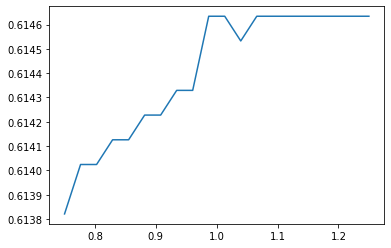

In [26]:
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(gs_svc.cv_results_)

plt.plot('param_linearsvc__C', 'mean_test_score', data=df_plot)

In [19]:
df_plot

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvc__C,param_linearsvc__class_weight,param_linearsvc__max_iter,param_linearsvc__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024800,0.001691,0.003400,0.000491,0.01,balanced,10000,123,"{'linearsvc__C': 0.01, 'linearsvc__class_weigh...",0.617378,0.614329,0.608740,0.616362,0.615346,0.614431,0.003022,2
1,0.056801,0.001630,0.003101,0.000374,1,balanced,10000,123,"{'linearsvc__C': 1, 'linearsvc__class_weight':...",0.615346,0.608232,0.611280,0.620427,0.617886,0.614634,0.004402,1
2,0.234600,0.032765,0.002601,0.000490,5,balanced,10000,123,"{'linearsvc__C': 5, 'linearsvc__class_weight':...",0.615346,0.607724,0.609248,0.620427,0.616362,0.613821,0.004701,3


[Run Next](https://github.com/gwoodstock/project4/blob/main/11_predict_petfinder.ipynb): Predict PetFinder API "Unseen" Data